In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import my_functions
%load_ext autoreload
%autoreload 2

## Carga de datos

Se realiza la carga de los archivos generados en los notebook 1.1 y 1.2, con la metadata de negocios y la de reseñas, en ambos casos ya con el filtro aplicado para identificar restaurantes.

In [2]:
# Cargar el archivo en un DataFrame
df_restaurants = pd.read_parquet('Datasets/Google Maps/1_metadata_restaurants/metadata_restaurants_v1.parquet')

df_reviews = pd.read_parquet('Datasets/Google Maps/2_reviews_restaurants/reviews_restaurants_v1.parquet')

df_id_restaurant = pd.read_parquet('Datasets/Google Maps/1_metadata_restaurants/df_id_restaurant.parquet')

Se verifica la carga de los archivos.

In [3]:
df_id_restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   gmap_id  210876 non-null  string
dtypes: string(1)
memory usage: 1.6 MB


In [4]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              210876 non-null  object 
 1   address           209823 non-null  object 
 2   gmap_id           210876 non-null  object 
 3   description       72167 non-null   object 
 4   latitude          210876 non-null  float64
 5   longitude         210876 non-null  float64
 6   category          210876 non-null  string 
 7   avg_rating        210876 non-null  float64
 8   num_of_reviews    210876 non-null  int64  
 9   price             99724 non-null   object 
 10  hours             188942 non-null  string 
 11  MISC              209475 non-null  string 
 12  state             189777 non-null  object 
 13  relative_results  170206 non-null  string 
 14  url               210876 non-null  object 
 15  categories        210876 non-null  object 
dtypes: float64(3), int64

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11407077 entries, 0 to 11882744
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     float64
 1   name        string 
 2   rating      int64  
 3   text        string 
 4   gmap_id     string 
 5   state_name  string 
 6   year        int32  
 7   month       int32  
dtypes: float64(1), int32(2), int64(1), string(4)
memory usage: 696.2 MB


## Identificación del estado correspondiente al restaurant

En la información de reseñas todos los registros cuentan con el nombre del estado. 

Esta información no se encuentra en la metadata, por lo cual se cruzará la información para poder consignar el estado correspondiente al restaurant.

Tomando la información de 'state_name' en el dataset 'df_reviews', se procede a extraer los estados que corresponden a cada restaurante y copiarlos en 'df_restaurants'.

In [6]:
# Extraer valores únicos de df_reviews['gmap_id']
reviews_gmap_id_unique = df_reviews['gmap_id'].unique()

# Crear un nuevo DataFrame con los valores únicos de gmap_id
df_reviews_gmap_id_unique = pd.DataFrame({'gmap_id': reviews_gmap_id_unique})

print("Valores únicos de 'gmap_id' encontrados en df_reviews:", len(reviews_gmap_id_unique) )

Valores únicos de 'gmap_id' encontrados en df_reviews: 127123


In [7]:
my_functions.describir_df(df_reviews, campos_incluir = ['gmap_id', 'state_name'])

Cantidad Registros:  11407077
Cantidad Campos:  2
Campos:
 Index(['gmap_id', 'state_name'], dtype='object')


,Campo,Tipo de Dato,Valores Nulos,% Nulos,Valores No Nulos,% No Nulos,Valores Únicos,% Únicos
0,gmap_id,[<class 'str'>],0,0.0,11407077,100.0,127123,1.11
1,state_name,[<class 'str'>],0,0.0,11407077,100.0,51,0.00


Tenemos 127173 restaurantes sobre los cuales se han realizado reseñas que contienen 51 nombres de distintos estados.

Se procede a copiar información de 'state_name' de estos estados a 'df_restaurants'.

In [8]:
# Merge para agregar la columna state_name a df_id_restaurants
df_id_restaurant = df_id_restaurant.merge(df_reviews[['gmap_id', 'state_name']], on='gmap_id', how='left')

# Eliminar filas duplicadas en df_id_restaurant
df_id_restaurant = df_id_restaurant.drop_duplicates()

# Merge para agregar state_name a df_restaurants
df_restaurants = pd.merge(df_restaurants, df_id_restaurant[['gmap_id', 'state_name']], on='gmap_id', how='left')

my_functions.describir_df(df_restaurants, campos_incluir = ['gmap_id', 'state_name'])

Cantidad Registros:  210876
Cantidad Campos:  2
Campos:
 Index(['gmap_id', 'state_name'], dtype='object')


,Campo,Tipo de Dato,Valores Nulos,% Nulos,Valores No Nulos,% No Nulos,Valores Únicos,% Únicos
0,gmap_id,[<class 'str'>],0,0.00,210876,100.00,210876,100.00
1,state_name,"[<class 'str'>, <class 'pandas._libs.missing.N...",83753,39.72,127123,60.28,51,0.02


Se puede observar que se ha creado exitosamente la columna 'state_name' para los 127123 restaurantes encontrados en las reseñas.

Sin embargo, la metadata refiere a 210876 restaurantes. Es decir, no se cuenta con información del estado para 74753 restaurantes.

In [9]:
my_functions.registros_al_azar(df_restaurants['state_name'], 10)

20621         New_Jersey
65295     North_Carolina
7631            Illinois
57149           New_York
169167              <NA>
113580             Texas
1187                <NA>
104656              <NA>
195048              <NA>
142373              <NA>
Name: state_name, dtype: string

Se identifica que los nombres compuestos presentan guión bajo para dividir las cadenas de texto. Se reemplazan por un espacio vacío.

In [10]:
# Reemplazar guiones bajos por espacios vacíos en df_reviews
df_reviews['state_name'] = df_reviews['state_name'].str.replace('_', ' ')

# Reemplazar guiones bajos por espacios vacíos en df_restaurants
df_restaurants['state_name'] = df_restaurants['state_name'].str.replace('_', ' ')

Se verifican modificaciones.

In [11]:
my_functions.registros_al_azar(df_restaurants['state_name'], 10)

63636           New York
132149    South Carolina
115501          New York
155915           Alabama
101256              <NA>
136524              Utah
68029            Georgia
182874              Ohio
94484               <NA>
20767      Massachusetts
Name: state_name, dtype: string

In [12]:
# Listas de abreviaturas 
state_abbrs = ['CA', 'IA', 'TX', 'ME', 'RI', 'OK', 'AR', 'MS', 'IN', 'LA', 'WA', 'NY', 'FL', 'PA', 'TN', 'SC', 'MA', 'OR', 'WI', 'CO', 'CT', 'NC', 'OH', 'DC', 'VA', 'HI', 'MD', 'IL', 'GA', 'MT', 'AZ', 'NJ', 'AL', 'UT', 'KY', 'NV', 'ID', 'MO', 'KS', 'MI', 'WY', 'ND', 'MN', 'NE', 'NH', 'VT', 'WV', 'AK', 'DE', 'SD']

# Creamos la nueva columna "estado" solo para los registros donde "state_name" está vacío
df_restaurants.loc[df_restaurants['state_name'].isna(), 'state_abbr'] = df_restaurants.loc[df_restaurants['state_name'].isna(), 'address'].astype(str).apply(lambda x: next((estado for estado in state_abbrs if estado in x), None))

df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              210876 non-null  object 
 1   address           209823 non-null  object 
 2   gmap_id           210876 non-null  object 
 3   description       72167 non-null   object 
 4   latitude          210876 non-null  float64
 5   longitude         210876 non-null  float64
 6   category          210876 non-null  string 
 7   avg_rating        210876 non-null  float64
 8   num_of_reviews    210876 non-null  int64  
 9   price             99724 non-null   object 
 10  hours             188942 non-null  string 
 11  MISC              209475 non-null  string 
 12  state             189777 non-null  object 
 13  relative_results  170206 non-null  string 
 14  url               210876 non-null  object 
 15  categories        210876 non-null  object 
 16  state_name        12

In [13]:
# Completa el diccionario con tus datos
state_names_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
    'DC': 'District of Columbia'
}

# Completamos los valores de "state_name" usando el diccionario "state_names_dict"
df_restaurants.loc[df_restaurants['state_name'].isna(), 'state_name'] = df_restaurants.loc[df_restaurants['state_name'].isna(), 'state_abbr'].map(state_names_dict)

# Completamos los valores de "state_abbr" usando el diccionario "state_names_dict"
df_restaurants.loc[df_restaurants['state_abbr'].isna(), 'state_abbr'] = df_restaurants.loc[df_restaurants['state_abbr'].isna(), 'state_name'].map({v: k for k, v in state_names_dict.items()})

In [14]:
df_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210876 entries, 0 to 210875
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              210876 non-null  object 
 1   address           209823 non-null  object 
 2   gmap_id           210876 non-null  object 
 3   description       72167 non-null   object 
 4   latitude          210876 non-null  float64
 5   longitude         210876 non-null  float64
 6   category          210876 non-null  string 
 7   avg_rating        210876 non-null  float64
 8   num_of_reviews    210876 non-null  int64  
 9   price             99724 non-null   object 
 10  hours             188942 non-null  string 
 11  MISC              209475 non-null  string 
 12  state             189777 non-null  object 
 13  relative_results  170206 non-null  string 
 14  url               210876 non-null  object 
 15  categories        210876 non-null  object 
 16  state_name        20

Quedan 1494 registros sin información sobre el estado.

Se retomará este punto al profundizar el análisis, ya que parece haber inconsistencia en algunos datos.

En una próxima etapa del proyecto se cruzarán estos datos con los de longitud y latitud con el objetivo de determinar si los estados consignados para cada restaurant son correctos.

## Exportación a archivos

Se almacenan el dataset con sus ultimas modificaciones.

In [25]:
# Exportar a formato Parquet
df_restaurants.to_parquet('Datasets/Google Maps/1_metadata_restaurants/metadata_restaurants_v2.parquet')

In [15]:
# Exportar a formato Parquet
df_reviews.to_parquet('Datasets/Google Maps/2_reviews_restaurants/reviews_restaurants_v2.parquet')

# EDA preliminar

En este análisis exploratorio se observarán algunas de las variables más relevantes, sus distribuciones y se establecerán algunas relaciones entre las mismas.

De la metadata de restaurantes tomaremos 'avg_rating', 'categories', 'MISC' y 'state_name'.
De las reseñas de restaurantes tomaremos 'rating', 'state_name', 'year' y 'month'.

Los campos que no se aborden en este punto se retomarán más adelante.

## Categorías

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


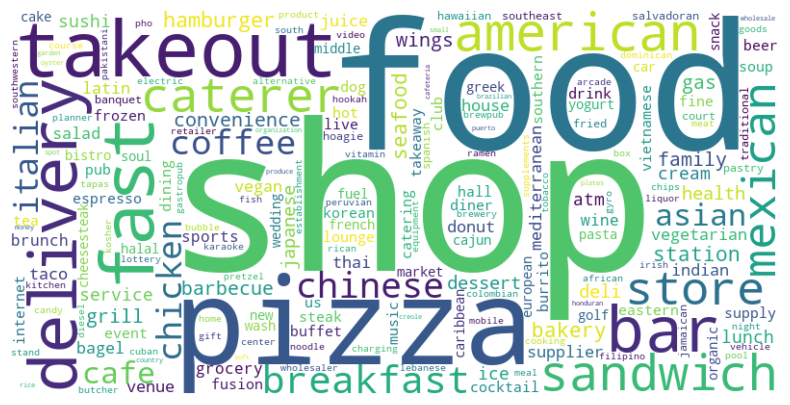

In [16]:
# Se realizan las importaciones necesarias
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import download
# Descargamos los recursos necesarios de nltk:
nltk.download('punkt')
nltk.download('stopwords')

# Combinamos todas las categorías en una sola cadena, separadas por comas:
all_categories = ','.join(df_restaurants['categories'].str.lower())

# Eliminamos la palabra 'restaurant' de la cadena:
all_categories = all_categories.replace('restaurant', '')

# Tokenizamos las palabras y eliminamos las stopwords:
stop_words = set(stopwords.words('spanish'))
tokens = [word for word in word_tokenize(all_categories) if word.isalpha() and word not in stop_words]

# Contamos la frecuencia de cada palabra:
word_freq = Counter(tokens)

# Filtramos las collocations en la tabla de frecuencias:
filtered_word_freq = {word: freq for word, freq in word_freq.items() if freq > 1}

# Convertimos el resultado en un DataFrame para visualización:
word_freq_df = pd.DataFrame(list(filtered_word_freq.items()), columns=['Palabra', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

# Creamos la nube de palabras:
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

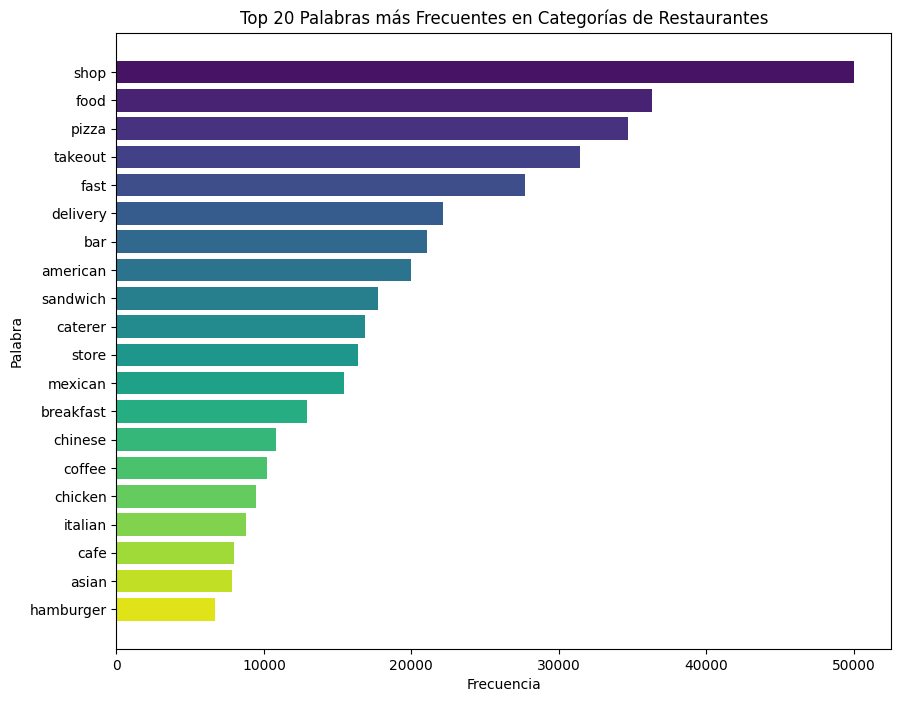

In [17]:
# Obtener los primeros 20 registros
top_20_words = word_freq_df.head(20)

# Obtener la paleta viridis
viridis_palette = sns.color_palette('viridis', n_colors=20)

# Crear un gráfico de barras horizontales con la paleta viridis
plt.figure(figsize=(10, 8))
plt.barh(top_20_words['Palabra'], top_20_words['Frecuencia'], color=viridis_palette)
plt.xlabel('Frecuencia')
plt.ylabel('Palabra')
plt.title('Top 20 Palabras más Frecuentes en Categorías de Restaurantes')
plt.gca().invert_yaxis()  # Invertir el eje y para que la palabra más frecuente esté en la parte superior
plt.show()

In [18]:
word_freq_df.head(1)

,Palabra,Frecuencia
29,shop,50047


## Atributos

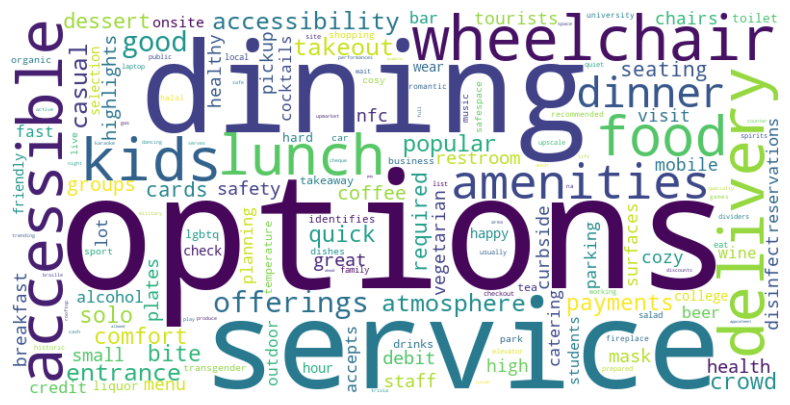

,Palabra,Frecuencia
1,options,417377
13,for,276872
37,dining,237755
0,service,228588
5,wheelchair,215802
6,accessible,215801
3,delivery,214158
14,kids,194075
34,lunch,175425
10,food,165712


In [19]:
# Combinamos todas las palabras en una sola cadena, separadas por comas:
misc = df_restaurants["MISC"].astype(str).str.replace("[", "").str.replace("]", "").str.replace("{", "").str.replace("}", "").str.replace("'", "").str.replace(",", "").str.replace(":", "")
misc = misc.dropna()
all_categories = ','.join(misc.str.lower())

# Eliminamos la palabra 'restaurant' de la cadena:
all_categories = all_categories.replace('restaurant', '')

# Tokenizamos las palabras y eliminamos las stopwords:
stop_words = set(stopwords.words('spanish'))
tokens = [word for word in word_tokenize(all_categories) if word.isalpha() and word not in stop_words]

# Creamos la nube de palabras:
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(' '.join(tokens))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Contamos la frecuencia de cada palabra:
word_freq = Counter(tokens)

# Filtramos las collocations en la tabla de frecuencias:
filtered_word_freq = {word: freq for word, freq in word_freq.items() if freq > 1}

# Convertimos el resultado en un DataFrame para visualización:
word_freq_df = pd.DataFrame(list(filtered_word_freq.items()), columns=['Palabra', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

word_freq_df.head(20)

## Reseñas por estado

In [20]:
registros_por_estado = df_reviews.groupby('state_name').size().reset_index(name='cantidad_registros').sort_values(by='cantidad_registros', ascending=False)
registros_por_estado

,state_name,cantidad_registros
9,Florida,956571
32,New York,745335
4,California,730028
43,Texas,547688
10,Georgia,509843
13,Illinois,483764
22,Michigan,433609
33,North Carolina,417511
35,Ohio,417141
38,Pennsylvania,410513


## Reseñas por año

In [21]:
registros_por_año = df_reviews.groupby('year').size().reset_index(name='cantidad_registros').sort_values(by='year')
registros_por_año

,year,cantidad_registros
0,1990,48
1,1999,2
2,2000,2
3,2001,2
4,2002,29
5,2003,50
6,2004,111
7,2005,194
8,2006,273
9,2007,257


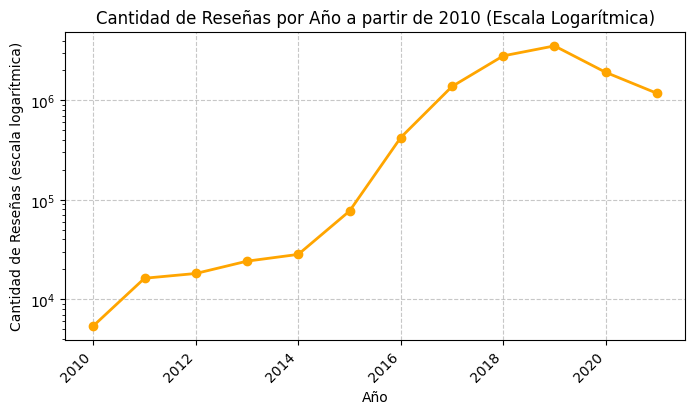

In [22]:
# Filtrar los datos para incluir solo años mayores o iguales a 2010
registros_por_año_filtrado = registros_por_año[registros_por_año['year'] >= 2010]

# Crear un gráfico de líneas con escala logarítmica en el eje y
plt.figure(figsize=(8, 4))
plt.plot(registros_por_año_filtrado['year'], registros_por_año_filtrado['cantidad_registros'], marker='o', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Año')
plt.ylabel('Cantidad de Reseñas (escala logarítmica)')
plt.yscale('log')  # Establecer escala logarítmica en el eje y
plt.title('Cantidad de Reseñas por Año a partir de 2010 (Escala Logarítmica)')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mayor legibilidad
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


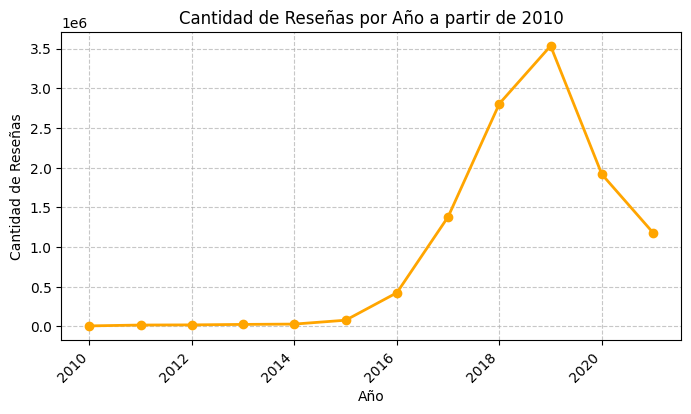

In [23]:
# Filtrar los datos para incluir solo años mayores o iguales a 2010
registros_por_año_filtrado = registros_por_año[registros_por_año['year'] >= 2010]

# Crear un gráfico de líneas
plt.figure(figsize=(8, 4))
plt.plot(registros_por_año_filtrado['year'], registros_por_año_filtrado['cantidad_registros'], marker='o', color='orange', linestyle='-', linewidth=2)
plt.xlabel('Año')
plt.ylabel('Cantidad de Reseñas')
plt.title('Cantidad de Reseñas por Año a partir de 2010')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas del eje x para mayor legibilidad
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


## Reseñas por rating

   rating  recuento
0       5   6527360
1       4   2602435
2       3   1192824
3       1    627325
4       2    457133


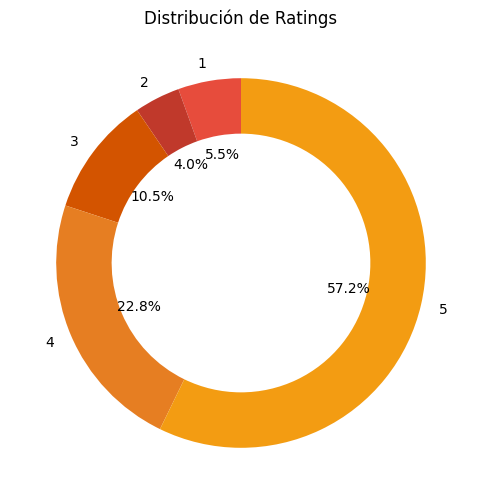

In [24]:
# Obtenemos la frecuencia de cada rating en la columna "rating":
frecuencia_rating = df_reviews["rating"].value_counts()

# Creamos un DataFrame a partir del resultado de value_counts:
df_frecuencia_rating = pd.DataFrame({"rating": frecuencia_rating.index, "recuento": frecuencia_rating.values}).head(10)

print(df_frecuencia_rating)

# Agrupamos el DataFrame por la columna "rating" y calcula el recuento para cada valor:
data = df_frecuencia_rating.groupby('rating')['recuento'].sum()

# Creamos un gráfico de dónut con etiquetas de porcentajes:
colores_rojos = ['#e74c3c', '#c0392b', '#d35400', '#e67e22', '#f39c12']
plt.figure(figsize=(6, 6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', colors=colores_rojos, startangle=90, wedgeprops=dict(width=0.3))
centro_circulo = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centro_circulo)
plt.title('Distribución de Ratings')
plt.show()